In [3]:
# imports

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
# device for GPUs

device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

## Data processing

In [ ]:
class BirdDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = f"{self.img_dir}/{row['image_path']}" 
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = row.get("label", -1)   # -1 for unlabeled data
        return image, label


In [ ]:
# CSVs with the image paths
train_df = pd.read_csv("/kaggle/input/dataset-aml-feathers/aml-2025-feathers-in-focus/train_images.csv")
test_df  = pd.read_csv("/kaggle/input/dataset-aml-feathers/aml-2025-feathers-in-focus/test_images_path.csv")

# convert labels to 0-199
train_df["label"] = train_df["label"] - 1

# create val_df with 1 image per class
val_df = train_df.groupby('label').apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)

# create train_df: the rest
train_df = train_df.drop(val_df.index).reset_index(drop=True)

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))


Train size: 3726
Val size: 200
Test size: 4000


/tmp/ipykernel_19/4201126127.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_df = train_df.groupby('label').apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)


## Res-Net training

Transfromations have been added iteratively with the objective of increasing the model performance by increasing the number of images (as the training dataset presents few images per class).

In [ ]:
train_tfms = transforms.Compose([
    transforms.Resize((256, 256)),   # same size
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),  # random zoom
    transforms.RandomHorizontalFlip(), # random flip
    transforms.RandomRotation(15),  # random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # color transforms
    transforms.ToTensor(), # convert to tensor
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3), value='random'),  # strong regularization
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]) # imagenet normalization
])

test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
# create datasets (applying transformations) and dataloaders
train_ds = BirdDataset(train_df, "/kaggle/input/dataset-aml-feathers/aml-2025-feathers-in-focus/train_images", train_tfms)
val_ds   = BirdDataset(val_df,   "/kaggle/input/dataset-aml-feathers/aml-2025-feathers-in-focus/train_images", test_tfms)
test_ds  = BirdDataset(test_df,  "/kaggle/input/dataset-aml-feathers/aml-2025-feathers-in-focus/test_images",  test_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=0)

print("Train loader size:", len(train_loader))
print("Val loader size:", len(val_loader))
print("Test loader size:", len(test_loader))

Train loader size: 117
Val loader size: 7
Test loader size: 125


In [ ]:
# basic block for ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)


# ResNet18 skinny
class ResNet18Skinny(nn.Module):
    def __init__(self, num_classes=200, dropout_rate=0.6):
        super().__init__()
        
        # smaller stem
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3, bias=False),  # 32 instead of 64
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # less channels in layers
        # standard: 64, 128, 256, 512
        # skinny:   32, 64,  128, 256
        self.layer1 = self._make_layer(32, 32, 2, stride=1)
        self.layer2 = self._make_layer(32, 64, 2, stride=2)
        self.layer3 = self._make_layer(64, 128, 2, stride=2)
        self.layer4 = self._make_layer(128, 256, 2, stride=2)
        
        # less parameters in final layer
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout_rate)  
        self.fc = nn.Linear(256, num_classes)  
        
        # initialize weight
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = [BasicBlock(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
# model, loss function, optimizer

model = ResNet18Skinny(num_classes=200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4) # bigger and smaller lr have been tested

In [ ]:
# function to train for one epoch (simplifies the training loop)
def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0

    for imgs, labels in tqdm(loader):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


# function to evaluate the model on validation set
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total


In [ ]:
# save them for plots
train_losses, val_losses = [], []
train_accs, val_accs = [], []

epochs = 100 # more epochs have been tested
patience = 5  # for early stopping     
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer)
    train_acc  = evaluate(model, train_loader)

    # validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            val_loss += criterion(outputs, labels).item()
    val_loss /= len(val_loader)

    val_acc = evaluate(model, val_loader)

    # save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # monitor progress
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}") 

    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "weights/resnet18Skinny.pth")  # save the best model
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        break

# save final model
torch.save(model.state_dict(), "weights/resnet18Skinny.pth")

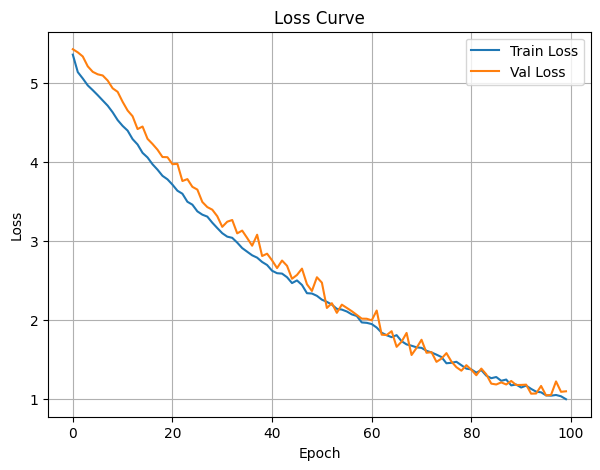

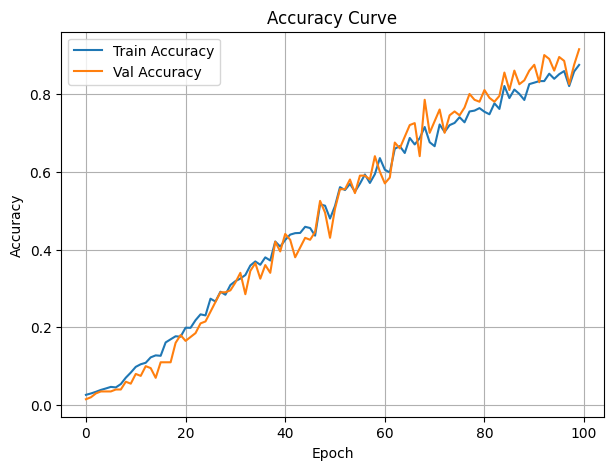

In [11]:
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7,5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)
plt.show()

The plots show that the model could continue learning, but the validation set is too small to consider it as a testing set. The use of only one image per class as validation is based on the trade-off of accuracy/monitoring, as increasing the validation set even by one image per class is highly impacting the training set.

## Inference on test

The data has been processed diferently for the inference, as the IDs of the images needed to be in the submission CSV for the test set.

In [ ]:
class BirdDataset(Dataset):
    def __init__(self, df, transform=None, is_test=False):
        self.df = df
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = row["image_path"]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            # handle the id for Kaggle submission
            sample_id = int(row["id"])
            return image, sample_id

        label = int(row["label"])
        return image, label

In [ ]:
def load_data():
    train_df = pd.read_csv("aml-2025-feathers-in-focus/train_images.csv")
    test_df = pd.read_csv("aml-2025-feathers-in-focus/test_images_path.csv")

    # convert labels to 0-199
    train_df["label"] = train_df["label"] - 1

    train_df["image_path"] = "aml-2025-feathers-in-focus/train_images/train_images/" + train_df["image_path"].str.split("/").str[-1]
    test_df["image_path"] = "aml-2025-feathers-in-focus/test_images/test_images/" + test_df["image_path"].str.split("/").str[-1]

    # print sizes
    print(f"Train: {len(train_df)} | Test: {len(test_df)}")
    return train_df, test_df

In [ ]:
# reload data with the IDs in the loaders
train_df, test_df = load_data()

train_ds = BirdDataset(train_df, transform=train_tfms, is_test=False)
test_ds  = BirdDataset(test_df,  transform=test_tfms,  is_test=True)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=0)

print("Train:", len(train_loader))
print("Test:", len(test_loader))


Train: 3926 | Test: 4000
Train: 123
Test: 125


In [ ]:
# load the previously saved best model

model = ResNet18Skinny(num_classes=200)
state_dict = torch.load("weights/resnet18Skinny.pth", map_location=torch.device(device))
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
model.to(device)
model.eval()

predictions = []

with torch.no_grad():
    for images, ids in tqdm(test_loader):

        images = images.to(device)

        logits = model(images)
        preds = torch.argmax(logits, dim=1) + 1   # reconvert to 1-200

        for i in range(len(preds)):
            predictions.append({
                "id": int(ids[i].item()),
                "label": int(preds[i].item())
            })

pred_df = pd.DataFrame(predictions)
pred_df.to_csv("submissions/submission_skinny.csv", index=False)